# Step 0: requirements and load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import os
import itertools
import collections
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
!wget 'http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-03-11.zip'
!unzip 'CSV-03-11.zip'

--2023-04-22 17:19:36--  http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-03-11.zip
Connecting to 205.174.165.80:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918815761 (876M) [application/zip]
Saving to: ‘CSV-03-11.zip’

CSV-03-11.zip       100%[===================>] 876.25M   941KB/s    in 14m 41s 

2023-04-22 17:34:18 (1018 KB/s) - ‘CSV-03-11.zip’ saved [918815761/918815761]

Archive:  CSV-03-11.zip
   creating: 03-11/
  inflating: 03-11/UDPLag.csv        
  inflating: 03-11/UDP.csv           
  inflating: 03-11/.~lock.UDPLag.csv#  
  inflating: 03-11/LDAP.csv          
  inflating: 03-11/MSSQL.csv         
  inflating: 03-11/NetBIOS.csv       
  inflating: 03-11/Portmap.csv       
  inflating: 03-11/Syn.csv           


# Step 1: Sampling

In [3]:
dataframes_paths = []
chunksize = 10 ** 6
dataset_directory = '03-11'
for path in os.listdir(dataset_directory):
  if path.endswith('.csv'):
    dataframes_paths.append(os.path.join(dataset_directory, path))
    l = 0
    for row in open(os.path.join(dataset_directory, path)):
      l+=1
    print(path, 'founded. it has', l, "records.")

NetBIOS.csv founded. it has 3455900 records.
UDPLag.csv founded. it has 725166 records.
LDAP.csv founded. it has 2113235 records.
Syn.csv founded. it has 4320542 records.
Portmap.csv founded. it has 191695 records.
MSSQL.csv founded. it has 5775787 records.
UDP.csv founded. it has 3782207 records.


In [4]:
def combine_dicts(dict1, dict2):
  Cdict = collections.defaultdict(int)
  for key, val in itertools.chain(dict1.items(), dict2.items()):
      Cdict[key] += val
  return dict(Cdict)

In [5]:
total_value_counts = {}
for df_path in dataframes_paths:
  df = pd.read_csv(df_path, chunksize=chunksize, low_memory=False)
  for chunk in df:
    total_value_counts = combine_dicts(total_value_counts, chunk[' Label'].value_counts().to_dict())

<Axes: ylabel='count'>

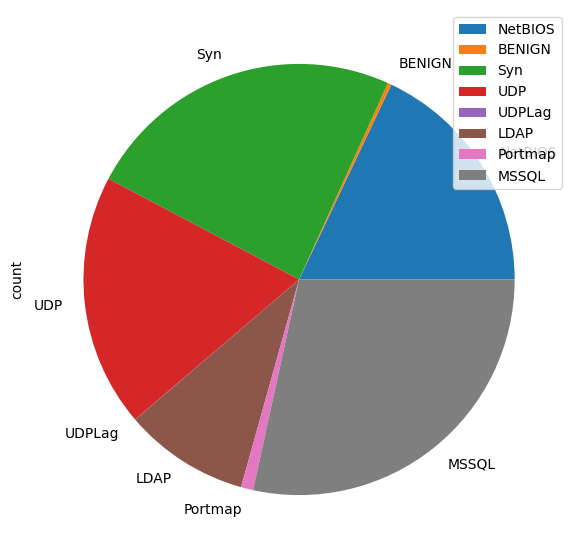

In [6]:
pd.DataFrame.from_dict(total_value_counts, orient='index', columns=['count']).plot.pie(y='count', figsize=(7,7))

In [ ]:
total_value_counts

{'MSSQL': 5787453,
 'LDAP': 1915122,
 'BENIGN': 56965,
 'UDP': 3867155,
 'Portmap': 186960,
 'Syn': 4891500,
 'UDPLag': 1873,
 'NetBIOS': 3657497}

In [ ]:
def sampling(df, sampled_value_counts, threshold = int(total_value_counts['BENIGN']/6)):
  sample = pd.DataFrame()
  df_values = df[' Label'].value_counts().to_dict()

  for k,v in df_values.items():
    if threshold>v or k == 'BENIGN':
      temp = df[df[' Label']== k]
      sample = pd.concat([sample, temp])
    elif threshold > sampled_value_counts[k]:
      temp = df[df[' Label']== k]
      sample = pd.concat([sample, temp.sample(threshold-sampled_value_counts[k])])
  return sample

In [ ]:
sampled_df = pd.DataFrame()
sampled_value_counts = {k:0 for k,v in total_value_counts.items()}
for df_path in dataframes_paths:
  df = pd.read_csv(df_path, chunksize=chunksize, low_memory=False)
  for chunk in df:
    sample = sampling(chunk, sampled_value_counts)
    sampled_value_counts = combine_dicts(sampled_value_counts, sample[' Label'].value_counts().to_dict())
    sampled_df = pd.concat([sampled_df, sample], ignore_index=True)
  print('one dataframe sampled!')
sampled_df

one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,91189,172.16.0.5-192.168.50.4-47035-50228-17,172.16.0.5,47035,192.168.50.4,50228,17,2018-11-03 10:54:50.815111,46,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
1,86277,172.16.0.5-192.168.50.4-34084-40567-17,172.16.0.5,34084,192.168.50.4,40567,17,2018-11-03 10:55:45.203849,989248,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
2,664,172.16.0.5-192.168.50.4-45458-10676-17,172.16.0.5,45458,192.168.50.4,10676,17,2018-11-03 10:55:51.528910,214329,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
3,51677,172.16.0.5-192.168.50.4-44562-19803-17,172.16.0.5,44562,192.168.50.4,19803,17,2018-11-03 10:55:13.589779,105498,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
4,122987,172.16.0.5-192.168.50.4-43630-58616-17,172.16.0.5,43630,192.168.50.4,58616,17,2018-11-03 10:55:57.635774,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115797,43,172.217.10.2-192.168.50.8-80-60002-6,192.168.50.8,60002,172.217.10.2,80,6,2018-11-03 10:08:59.730537,41177,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN
115798,44,192.168.50.8-74.208.236.171-60001-80-6,192.168.50.8,60001,74.208.236.171,80,6,2018-11-03 10:08:59.730586,55337,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN
115799,324450,172.217.10.2-192.168.50.8-80-60002-6,172.217.10.2,80,192.168.50.8,60002,6,2018-11-03 10:08:59.771715,158,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,BENIGN
115800,196126,192.168.50.8-74.208.236.171-60001-80-6,74.208.236.171,80,192.168.50.8,60001,6,2018-11-03 10:08:59.785924,162,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,BENIGN


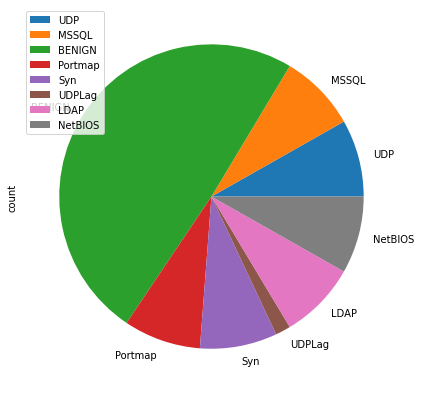

In [ ]:
pd.DataFrame.from_dict(sampled_value_counts, orient='index', columns=['count']).plot.pie(y='count', figsize=(7,7))

# Step 2: Pre-Processing

##1

In [ ]:
null_columns=sampled_df.columns[sampled_df.isna().any()]
sampled_df[null_columns].isna().sum().sort_values(ascending=False)

Flow Bytes/s    42
dtype: int64

In [ ]:
print("before drop nulls:", sampled_df.shape)
preprocessed_df = sampled_df.dropna()
print("after drop nulls:", preprocessed_df.shape)

before drop nulls: (115802, 88)
after drop nulls: (115760, 88)


## 2,3

In [ ]:
preprocessed_df.nunique().sort_values(ascending=True).head(15)

 Fwd URG Flags           1
Bwd Avg Bulk Rate        1
 Bwd Avg Packets/Bulk    1
 Bwd Avg Bytes/Bulk      1
 Fwd Avg Bulk Rate       1
 Fwd Avg Packets/Bulk    1
 Bwd URG Flags           1
Fwd Avg Bytes/Bulk       1
 ECE Flag Count          1
 Bwd PSH Flags           1
FIN Flag Count           1
 PSH Flag Count          1
 Inbound                 2
 SYN Flag Count          2
 CWE Flag Count          2
dtype: int64

In [ ]:
temp = preprocessed_df.nunique()
single_value_columns = [c for c in preprocessed_df.columns if temp[c] == 1]
preprocessed_df = preprocessed_df.drop(columns=single_value_columns)
preprocessed_df.nunique().sort_values(ascending=True).head(10)

Fwd PSH Flags       2
 CWE Flag Count     2
 URG Flag Count     2
 ACK Flag Count     2
 RST Flag Count     2
 SYN Flag Count     2
 Inbound            2
 Protocol           3
 Label              8
 Down/Up Ratio     15
dtype: int64

In [ ]:
preprocessed_df.nunique().sort_values(ascending=False).head(15)

 Timestamp           111291
Flow ID               81455
Unnamed: 0            71011
 Destination Port     40386
Flow Bytes/s          38896
 Flow IAT Std         35847
 Flow IAT Mean        32589
 Flow Packets/s       32447
Fwd Packets/s         32040
 Source Port          31635
 Flow Duration        30863
 Flow IAT Max         29552
 Bwd Packets/s        25077
 Fwd IAT Std          22232
 Fwd IAT Mean         20967
dtype: int64

In [ ]:
preprocessed_df.columns[preprocessed_df.dtypes == object]

Index(['Flow ID', ' Source IP', ' Destination IP', ' Timestamp',
       'SimillarHTTP', ' Label'],
      dtype='object')

In [ ]:
preprocessed_df[preprocessed_df['SimillarHTTP'] != '0']

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
19052,29,192.168.50.8-74.208.236.171-60320-80-6,192.168.50.8,60320,74.208.236.171,80,6,2018-11-03 10:43:33.718282,15369071,12,...,0.0,366188.0,366188.0,10013194.0,0.0,10013194.0,10013194.0,drmokhberi.ca/2018/04/18/installing-docker-ce-...,0,BENIGN
19053,31,192.168.50.8-74.208.236.171-60321-80-6,192.168.50.8,60321,74.208.236.171,80,6,2018-11-03 10:43:33.725513,15601511,10,...,0.0,800889.0,800889.0,9805271.0,0.0,9805271.0,9805271.0,drmokhberi.ca/favicon.ico,0,BENIGN
19242,181,192.168.50.8-74.208.236.171-60346-80-6,192.168.50.8,60346,74.208.236.171,80,6,2018-11-03 10:47:25.062156,478492,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,talebi.ca/resume/,0,BENIGN
19245,180,192.168.50.8-74.208.236.171-60347-80-6,192.168.50.8,60347,74.208.236.171,80,6,2018-11-03 10:47:25.067864,472639,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,talebi.ca/wp-content/uploads/dynamic_avia/enfo...,0,BENIGN
19320,186,192.168.50.8-72.167.239.239-60372-80-6,192.168.50.8,60372,72.167.239.239,80,6,2018-11-03 10:47:26.865652,71271,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ocsp.godaddy.com/,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115731,168520,172.217.2.174-192.168.50.8-80-60005-6,192.168.50.8,60005,172.217.2.174,80,6,2018-11-03 10:08:54.563370,1245411,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ocsp.pki.goog/GTSGIAG3,0,BENIGN
115732,169251,172.217.2.174-192.168.50.8-80-60006-6,192.168.50.8,60006,172.217.2.174,80,6,2018-11-03 10:08:54.563483,516201,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ocsp.pki.goog/GTSGIAG3,0,BENIGN
115745,149484,172.217.2.174-192.168.50.8-80-60013-6,192.168.50.8,60013,172.217.2.174,80,6,2018-11-03 10:08:54.780616,279099,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ocsp.pki.goog/GTSGIAG3,0,BENIGN
115746,150220,172.217.2.174-192.168.50.8-80-60014-6,192.168.50.8,60014,172.217.2.174,80,6,2018-11-03 10:08:54.780952,1147797,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ocsp.pki.goog/GTSGIAG3,0,BENIGN


In [ ]:
preprocessed_df = preprocessed_df.drop(columns=[
                                                ' Timestamp',
                                                'Flow ID',
                                                'Unnamed: 0',
                                                ' Destination Port',
                                                ' Source Port',    
                                                ' Source IP',
                                                ' Destination IP',
                                                'SimillarHTTP',
])

## 4

In [ ]:
preprocessed_df[' Label'].unique()

array(['UDP', 'MSSQL', 'BENIGN', 'Portmap', 'Syn', 'UDPLag', 'LDAP',
       'NetBIOS'], dtype=object)

In [ ]:
preprocessed_df[' Label'] = preprocessed_df[' Label'].replace(
    ['NetBIOS', 'BENIGN', 'MSSQL', 'LDAP', 'Portmap', 'Syn', 'UDP','UDPLag'],
     [1, 0, 1, 1, 1, 1, 1, 1])

In [ ]:
preprocessed_df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

## 5

In [ ]:
for c in list(preprocessed_df.columns):
  temp = np.isinf(preprocessed_df[c]).values.sum()
  if temp>0:
    print(c, temp)

Flow Bytes/s 3009
 Flow Packets/s 3009


In [ ]:
infinite_columns = ['Flow Bytes/s', ' Flow Packets/s']
for c in infinite_columns:
  temp = preprocessed_df[preprocessed_df[c] != float('inf')]
  c_max = np.max(temp[c])
  print(c_max)
  preprocessed_df.loc[preprocessed_df[c] == float('inf'), c] = c_max

2944000000.0
3000000.0


In [ ]:
def z_score(df):
  df_std = df.copy()
  for column in df_std.columns:
    if df_std[column].std() != 0:
      df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
    else:
      df_std[column] = 0
  return df_std

In [ ]:
normalized_df = z_score(preprocessed_df.loc[:, preprocessed_df.columns != ' Label'])
normalized_df[' Label'] = preprocessed_df[' Label']

In [ ]:
outliers = pd.DataFrame()
for c in normalized_df.columns:
  temp = normalized_df[normalized_df[c]>10]
  outliers = pd.concat([outliers, temp])
  temp = normalized_df[normalized_df[c]<-10]
  outliers = pd.concat([outliers, temp])

outliers = outliers.drop_duplicates(keep=False)
outliers

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
20761,-1.109530,0.120051,0.023473,0.064301,4.327947,-0.011855,5.455945,-0.587925,2.015423,11.585176,...,-0.065567,-0.105794,-0.098753,-0.035784,0.672717,-0.105310,0.616749,0.712516,-1.226328,0
21508,-1.109530,0.140155,0.023473,0.026529,5.127973,-0.011919,5.455945,-0.587925,2.473392,10.286713,...,0.038179,-0.105794,-0.023757,0.077932,0.773040,-0.105310,0.711363,0.816119,-1.226328,0
21657,-1.109530,0.146496,0.042497,0.102073,7.810488,-0.002556,6.025396,-0.587925,2.715659,11.470740,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.105310,-0.237350,-0.222728,-1.226328,0
21671,-1.109530,-0.061434,0.004449,0.064301,2.888435,-0.016410,6.357400,-0.587925,2.340358,14.005419,...,-0.071479,-0.105794,-0.103027,-0.042265,0.278359,-0.105310,0.244832,0.305265,-1.226328,0
21713,-1.109530,-0.059879,0.000644,0.045415,1.687398,-0.016473,5.636656,-0.587925,1.490287,11.718199,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.105310,-0.237350,-0.222728,-1.226328,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111941,-1.109530,2.648586,0.122399,0.309820,4.780251,0.023812,5.119737,-0.602672,0.326797,7.567375,...,0.786649,1.131440,0.840256,0.408621,3.326441,17.629946,5.372320,0.986104,-1.226328,0
111967,0.873705,1.981363,0.034888,0.102073,-0.144466,-0.010411,-0.606291,-0.524021,-0.563941,-0.250197,...,0.060891,0.023907,0.026517,0.051490,2.547082,16.649188,4.512728,0.317683,-1.226328,0
112035,-1.109530,4.274315,0.126204,0.536453,1.001948,-0.006984,1.255456,-0.587925,-0.400478,1.777362,...,2.169303,7.233486,5.579235,0.278909,2.475785,12.456178,5.392282,0.561828,-1.226328,0
112040,-1.109530,3.095587,0.103375,0.385364,0.272533,-0.010632,-0.312110,-0.587925,-0.516629,0.397605,...,0.174838,0.093718,0.123372,0.099191,2.529068,14.135937,5.321488,0.988991,-1.226328,0


In [ ]:
normalized_df = normalized_df.drop(list(outliers.index))
normalized_df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,0.873705,-0.271696,-0.018380,-0.049015,-0.109161,-0.021281,-0.005321,0.186300,0.148656,-0.263041,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,0.815435,1
1,0.873705,-0.231240,0.050107,-0.049015,2.089076,-0.021281,0.162783,0.186300,0.250526,0.042885,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,0.815435,1
2,0.873705,-0.262933,-0.003161,-0.049015,0.372452,-0.021281,0.145973,0.186300,0.215578,0.093259,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,0.815435,1
3,0.873705,-0.267384,-0.010771,-0.049015,0.142637,-0.021281,0.095541,0.208420,0.219296,-0.034399,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,0.815435,1
4,0.873705,-0.271698,-0.018380,-0.049015,-0.073190,-0.021281,0.108149,0.319024,0.282500,-0.263041,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,0.815435,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115797,-1.109530,-0.270014,-0.022185,-0.039572,-0.320991,-0.021249,-0.667229,-0.587925,-0.632103,-0.263041,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,-1.226328,0
115798,-1.109530,-0.269435,-0.022185,-0.039572,-0.320991,-0.021249,-0.667229,-0.587925,-0.632103,-0.263041,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,-1.226328,0
115799,-1.109530,-0.271692,-0.022185,-0.030129,-0.320991,-0.021218,-0.667229,-0.587925,-0.632103,-0.263041,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,0.815435,0
115800,-1.109530,-0.271692,-0.022185,-0.030129,-0.320991,-0.021218,-0.667229,-0.587925,-0.632103,-0.263041,...,-0.118361,-0.105794,-0.136917,-0.093652,-0.232918,-0.10531,-0.23735,-0.222728,0.815435,0


## 6

In [ ]:
# normalized_df.to_csv('drive/MyDrive/normalized_df.csv')
normalized_df = pd.read_csv('drive/MyDrive/normalized_df.csv')
normalized_df = normalized_df.drop(columns=['Unnamed: 0'])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(normalized_df, test_size=0.15, shuffle=True)
train_df.shape

(97632, 68)

In [ ]:
temp = train_df.loc[:, train_df.columns != ' Label']
x_train = temp.to_numpy()
y_train = train_df[' Label'].to_numpy()
x_train.shape, y_train.shape

((97632, 67), (97632,))

In [ ]:
temp = test_df.loc[:, test_df.columns != ' Label']
x_test = temp.to_numpy()
y_test = test_df[' Label'].to_numpy()
x_test.shape, y_test.shape

((17230, 67), (17230,))

# Step 3: Mining algorithms

## Neural network

In [ ]:
model = tf.keras.models.Sequential(layers=[
                                    tf.keras.layers.Dense(units=67, activation='relu', input_shape=(67,)),
                                    tf.keras.layers.Dense(units=100, activation = 'relu'),
                                    tf.keras.layers.Dense(units=1, activation = 'sigmoid'),
])

In [ ]:
model.compile(
        loss = 'binary_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics = [ 'accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                  ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 67)                4556      
                                                                 
 dense_4 (Dense)             (None, 100)               6800      
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,457
Trainable params: 11,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x = x_train,
          y = y_train,
          batch_size=64,
          epochs=5,
          validation_split=0.1,
          )

Epoch 1/5
1373/1373 [==============================] - 4s 3ms/step - loss: 0.0207 - accuracy: 0.9955 - precision_1: 0.9977 - recall_1: 0.9934 - val_loss: 0.0158 - val_accuracy: 0.9970 - val_precision_1: 0.9972 - val_recall_1: 0.9970
Epoch 2/5
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0093 - accuracy: 0.9981 - precision_1: 0.9986 - recall_1: 0.9977 - val_loss: 0.0146 - val_accuracy: 0.9961 - val_precision_1: 0.9954 - val_recall_1: 0.9970
Epoch 3/5
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0079 - accuracy: 0.9983 - precision_1: 0.9987 - recall_1: 0.9980 - val_loss: 0.0100 - val_accuracy: 0.9973 - val_precision_1: 0.9980 - val_recall_1: 0.9968
Epoch 4/5
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0072 - accuracy: 0.9983 - precision_1: 0.9988 - recall_1: 0.9979 - val_loss: 0.0129 - val_accuracy: 0.9974 - val_precision_1: 0.9976 - val_recall_1: 0.9974
Epoch 5/5
1373/1373 [==============================] - 3s 2ms/step -

## Desicion tree

In [ ]:
from sklearn.tree import export_graphviz
import subprocess

def visualize_tree(tree, feature_names):
  with open("dt.dot", 'w') as f:
      export_graphviz(tree, out_file=f,
                      feature_names=feature_names)

  command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
  try:
      subprocess.check_call(command)
  except:
      exit("Could not run dot, ie graphviz, to "
            "produce visualization")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(dataframe, target_column, is_visualize=False, is_print=True):
  y = dataframe[target_column]
  X = dataframe.drop(columns = [target_column])

  if is_print:
    print("number of unique values of each column:")
    print(dataframe.nunique().sort_values(ascending=False))

  dt = DecisionTreeClassifier()
  dt.fit(X, y)
  
  if is_visualize:
    visualize_tree(dt, X.columns)
    print("\ntree schema saved on dt.png")
  
  best_attributes = pd.DataFrame(dt.feature_importances_, 
                                 index = X.columns, 
                                 columns=['importance']).sort_values('importance',
                                                                     ascending=False)
  if is_print:
    print("\nthe most important features (features on top of the tree): ")
    print(best_attributes)
  return list(best_attributes.index), dt

In [ ]:
best_attributes, dt = decision_tree(train_df, ' Label')

number of unique values of each column:
Flow Bytes/s       33294
 Flow IAT Std      30620
 Flow Packets/s    27773
 Flow IAT Mean     27693
Fwd Packets/s      27456
                   ...  
 RST Flag Count        2
 SYN Flag Count        2
Fwd PSH Flags          2
 Inbound               2
 Label                 2
Length: 68, dtype: int64

the most important features (features on top of the tree): 
                              importance
 Min Packet Length              0.708941
 URG Flag Count                 0.163024
 Inbound                        0.101902
 Average Packet Size            0.013626
 Fwd IAT Min                    0.005135
...                                  ...
 Fwd IAT Std                    0.000000
 RST Flag Count                 0.000000
 Fwd Packet Length Max          0.000000
 Total Length of Bwd Packets    0.000000
 Packet Length Variance         0.000000

[67 rows x 1 columns]


## SVM

In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC(random_state=0)
svm_classifier.fit(x_train, y_train)
SVC(random_state=0)

SVC(random_state=0)

# Step 4: Evaluate

In [ ]:
def calculate_metrics(y_predict, y_test):
  tp = 0
  tn = 0
  fn = 0
  fp = 0
  for i in range(y_test.shape[0]):
    if y_test[i] == 1:
      if y_predict[i] == 1:
        tp += 1
      elif y_predict[i] == 0:
        fn += 1
    elif y_test[i] == 0:
      if y_predict[i] == 0:
        tn += 1
      elif y_predict[i] == 1:
        fp += 1
  return tp, fn, tn, fp

def accuracy(y_predict, y_test):
  tp, fn, tn, fp = calculate_metrics(y_predict, y_test)
  return (tp+tn)/(tp+tn+fn+fp)

def precision(y_predict, y_test):
  tp, fn, tn, fp = calculate_metrics(y_predict, y_test)
  return (tp)/(tp+fp)

def recall(y_predict, y_test):
  tp, fn, tn, fp = calculate_metrics(y_predict, y_test)
  return (tp)/(tp+fn)

def f1_score(y_predict, y_test, beta=0.5):
  r = recall(y_predict, y_test)
  p = precision(y_predict, y_test)
  return ((1+beta**2)*p*r)/((beta**2 * p )+ r)

In [ ]:
model_predictions = model.predict(x_test)

model_predictions[model_predictions>0.5] = 1
model_predictions[model_predictions<=0.5] = 0

print("test accuracy of neural network model is:", round(accuracy(model_predictions, y_test)*100,2), '%')
print("test presicion of neural network model is:", round(precision(model_predictions, y_test)*100,2), '%')
print("test recall of neural network model is:", round(recall(model_predictions, y_test)*100,2), '%')
print("test f1_score of neural network model is:", round(f1_score(model_predictions, y_test)*100,2), '%')

test accuracy of neural network model is: 99.88 %
test presicion of neural network model is: 99.93 %
test recall of neural network model is: 99.84 %
test f1_score of neural network model is: 99.91 %


In [ ]:
train_result = model.evaluate(x_train, y_train)
test_result = model.evaluate(x_test, y_test)
print("test accuracy of neural network model is:", round(test_result[1]*100,2), '%')
print("test presicion of neural network model is:", round(test_result[2]*100,2), '%')
print("test recall of neural network model is:", round(test_result[3]*100,2), '%')

539/539 [==============================] - 1s 2ms/step - loss: 0.0049 - accuracy: 0.9988 - precision_1: 0.9993 - recall_1: 0.9984
test accuracy of neural network model is: 99.88 %
test presicion of neural network model is: 99.93 %
test recall of neural network model is: 99.84 %


test accuracy of svm model is: 99.88 %
test presicion of svm model is: 99.93 %
test recall of svm model is: 99.83 %
test f1_score of svm model is: 99.88 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


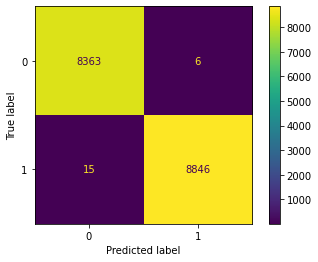

In [ ]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

svm_predictions = svm_classifier.predict(x_test)

print("test accuracy of svm model is:", round(accuracy_score(y_test, svm_predictions)*100,2), '%')
print("test presicion of svm model is:", round(precision_score(y_test, svm_predictions)*100,2), '%')
print("test recall of svm model is:", round(recall_score(y_test, svm_predictions)*100,2), '%')
print("test f1_score of svm model is:", round(f1_score(y_test, svm_predictions)*100,2), '%')

plot_confusion_matrix(svm_classifier, x_test, y_test)

test accuracy of decision tree model is: 99.98 %
test presicion of decision tree model is: 99.99 %
test recall of decision tree model is: 99.98 %
test f1_score of decision tree model is: 99.98 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


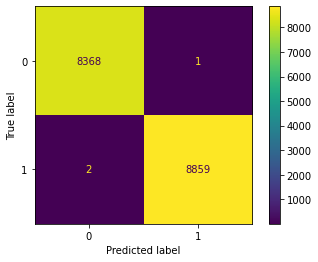

In [ ]:
dt_predictions = dt.predict(test_df.loc[:, test_df.columns != ' Label'])

print("test accuracy of decision tree model is:", round(accuracy(dt_predictions, y_test)*100,2), '%')
print("test presicion of decision tree model is:", round(precision(dt_predictions, y_test)*100,2), '%')
print("test recall of decision tree model is:", round(recall(dt_predictions, y_test)*100,2), '%')
print("test f1_score of decision tree model is:", round(f1_score(dt_predictions, y_test)*100,2), '%')

plot_confusion_matrix(dt, x_test, y_test)

# Step 5: Find the most important attributes

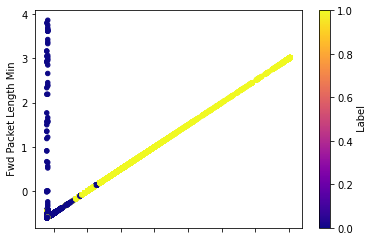

In [ ]:
train_df.plot(x= ' Min Packet Length', y =' Fwd Packet Length Min', kind = 'scatter', c=' Label', colormap='plasma')
plt.show()

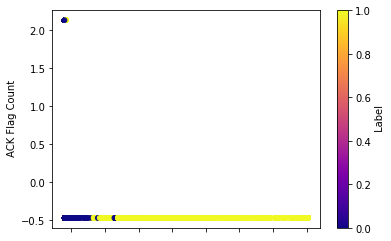

In [ ]:
train_df.plot(x= ' Min Packet Length', y=' ACK Flag Count', kind = 'scatter', c=' Label', colormap='plasma')
plt.show()

In [ ]:
correlations = train_df.corr()[' Label'].sort_values()
correlations.head(10)

 URG Flag Count           -0.576622
 Down/Up Ratio            -0.479955
 Bwd Packet Length Min    -0.365127
 CWE Flag Count           -0.350544
 RST Flag Count           -0.313886
Fwd PSH Flags             -0.313886
 Packet Length Std        -0.305116
 Bwd Packet Length Mean   -0.298638
 Avg Bwd Segment Size     -0.298638
Init_Win_bytes_forward    -0.293132
Name:  Label, dtype: float64

In [ ]:
correlations.tail(10)

 Average Packet Size       0.507911
 Fwd Packet Length Mean    0.528349
 Avg Fwd Segment Size      0.528349
Fwd Packets/s              0.536647
 Flow Packets/s            0.549108
 Fwd Packet Length Min     0.555474
 Protocol                  0.556413
 Min Packet Length         0.558173
 Inbound                   0.799062
 Label                     1.000000
Name:  Label, dtype: float64

In [ ]:
train_df.groupby(' Label')[' Inbound', ' Min Packet Length', 
                                  ' ACK Flag Count', ' Fwd IAT Min', 
                                  ' URG Flag Count', ' Down/Up Ratio'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Inbound,Min Packet Length,ACK Flag Count,Fwd IAT Min,URG Flag Count,Down/Up Ratio
Label,,,,,,
0,-0.812109,-0.567156,0.045313,0.027404,0.583605,0.470347
1,0.785103,0.551241,-0.051562,-0.022803,-0.567021,-0.464006


In [ ]:
temp = train_df[best_attributes[:3] + [' Label']]
b, new_dt = decision_tree(temp, ' Label', is_visualize=True)

number of unique values of each column:
 Min Packet Length    565
 URG Flag Count         2
 Inbound                2
 Label                  2
dtype: int64

tree schema saved on dt.png

the most important features (features on top of the tree): 
                    importance
 Min Packet Length    0.732459
 URG Flag Count       0.164161
 Inbound              0.103380


0.9982008125362739


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


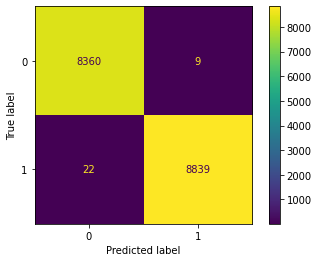

In [ ]:
temp_test = test_df[best_attributes[:3]]
new_dt_preds = new_dt.predict(temp_test)
print(accuracy(new_dt_preds, y_test))
plot_confusion_matrix(new_dt, temp_test, y_test)

#Step 6: P-value

In [ ]:
# 10-fold algorithm
def k_fold(df, k=10):
  accuracies = []
  for i in range(k):
    train_df, test_df = train_test_split(df, test_size=1.0/k, shuffle=True)
    temp = train_df.loc[:, train_df.columns != ' Label']
    x_train = temp.to_numpy()
    y_train = train_df[' Label'].to_numpy()
    temp = test_df.loc[:, test_df.columns != ' Label']
    x_test = temp.to_numpy()
    y_test = test_df[' Label'].to_numpy()

    best_attributes, dt = decision_tree(train_df, ' Label', is_print=False)
    dt_predictions = dt.predict(test_df.loc[:, test_df.columns != ' Label'])
    temp = round(accuracy(dt_predictions, y_test)*100,2)
    accuracies.append(temp)
    print('fold',i,'done with accuracy:', temp, '%')
  return accuracies

In [ ]:
from scipy import stats

whole_dt_accuracies = k_fold(normalized_df)
stats.ttest_1samp(whole_dt_accuracies, 0)

fold 0 done with accuracy: 99.98 %
fold 1 done with accuracy: 99.97 %
fold 2 done with accuracy: 99.96 %
fold 3 done with accuracy: 99.97 %
fold 4 done with accuracy: 99.96 %
fold 5 done with accuracy: 99.98 %
fold 6 done with accuracy: 99.95 %
fold 7 done with accuracy: 99.95 %
fold 8 done with accuracy: 99.96 %
fold 9 done with accuracy: 99.97 %


Ttest_1sampResult(statistic=29266.75523768695, pvalue=3.2322104724211677e-37)

In [ ]:
temp_df = normalized_df[[' Min Packet Length',' URG Flag Count',' Inbound', ' Label']]
new_dt_accuracies = k_fold(temp_df)
stats.ttest_1samp(new_dt_accuracies, 0)

fold 0 done with accuracy: 99.79 %
fold 1 done with accuracy: 99.76 %
fold 2 done with accuracy: 99.83 %
fold 3 done with accuracy: 99.82 %
fold 4 done with accuracy: 99.85 %
fold 5 done with accuracy: 99.79 %
fold 6 done with accuracy: 99.85 %
fold 7 done with accuracy: 99.83 %
fold 8 done with accuracy: 99.78 %
fold 9 done with accuracy: 99.85 %


Ttest_1sampResult(statistic=9639.475617551636, pvalue=7.085817732643563e-33)

# Step 7: Detect type of attack

one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!
one dataframe sampled!


<AxesSubplot:ylabel='count'>

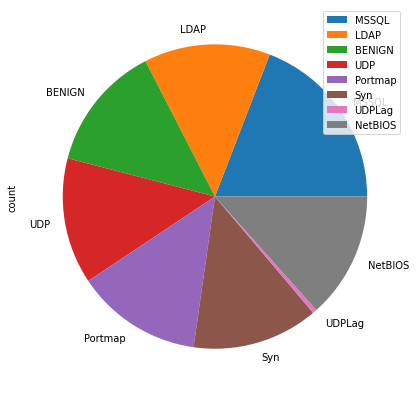

In [ ]:
sampled_df = pd.DataFrame()
sampled_value_counts = {k:0 for k,v in total_value_counts.items()}
for df_path in dataframes_paths:
  df = pd.read_csv(df_path, chunksize=chunksize, low_memory=False)
  for chunk in df:
    sample = sampling(chunk, sampled_value_counts, threshold = int(total_value_counts['BENIGN']))
    sampled_value_counts = combine_dicts(sampled_value_counts, sample[' Label'].value_counts().to_dict())
    sampled_df = pd.concat([sampled_df, sample], ignore_index=True)
  print('one dataframe sampled!')
pd.DataFrame.from_dict(sampled_value_counts, orient='index', columns=['count']).plot.pie(y='count', figsize=(7,7))

In [ ]:
preprocessed_df = sampled_df.dropna()

temp = preprocessed_df.nunique()
single_value_columns = [c for c in preprocessed_df.columns if temp[c] == 1]
preprocessed_df = preprocessed_df.drop(columns=single_value_columns)

preprocessed_df = preprocessed_df.drop(columns=[
                                                ' Timestamp',
                                                'Flow ID',
                                                'Unnamed: 0',
                                                ' Destination Port',
                                                ' Source Port',    
                                                ' Source IP',
                                                ' Destination IP',
                                                'SimillarHTTP',
])

preprocessed_df[' Label'] = preprocessed_df[' Label'].replace(
    ['NetBIOS', 'BENIGN', 'MSSQL', 'LDAP', 'Portmap', 'Syn', 'UDP','UDPLag'],
     [1, 0, 2, 3, 4, 5, 6, 7])

infinite_columns = ['Flow Bytes/s', ' Flow Packets/s']
for c in infinite_columns:
  temp = preprocessed_df[preprocessed_df[c] != float('inf')]
  c_max = np.max(temp[c])
  preprocessed_df.loc[preprocessed_df[c] == float('inf'), c] = c_max

preprocessed_df

# normalized_df = z_score(preprocessed_df.loc[:, preprocessed_df.columns != ' Label'])
# normalized_df[' Label'] = preprocessed_df[' Label']

# train_df, test_df = train_test_split(normalized_df, test_size=0.15, shuffle=True)
# temp = train_df.loc[:, train_df.columns != ' Label']
# x_train = temp.to_numpy()
# y_train = train_df[' Label'].to_numpy()
# temp = test_df.loc[:, test_df.columns != ' Label']
# x_test = temp.to_numpy()
# y_test = test_df[' Label'].to_numpy()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,17,1,2,0,962.0,0.0,481.0,481.0,481.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
1,17,1,2,0,1174.0,0.0,587.0,587.0,587.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
2,17,1,2,0,1228.0,0.0,614.0,614.0,614.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
3,17,1,2,0,802.0,0.0,401.0,401.0,401.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
4,17,5,2,0,1488.0,0.0,744.0,744.0,744.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425015,6,26346,2,2,12.0,0.0,6.0,6.0,6.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
425016,6,1058092,4,2,24.0,0.0,6.0,6.0,6.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
425017,6,1053786,4,2,24.0,0.0,6.0,6.0,6.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
425018,6,77893,4,4,104.0,104.0,46.0,6.0,26.0,23.094011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
from google.colab import files
files.download("DDos_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
preprocessed_df.to_csv(r'DDos_dataset.csv', index=False)

In [ ]:
best_attributes, dt = decision_tree(train_df, ' Label')

number of unique values of each column:
 Flow IAT Std      51962
Flow Bytes/s       50828
 Flow IAT Mean     40952
 Flow Packets/s    40857
Fwd Packets/s      40363
                   ...  
 ACK Flag Count        2
 RST Flag Count        2
 SYN Flag Count        2
Fwd PSH Flags          2
 Inbound               2
Length: 68, dtype: int64

the most important features (features on top of the tree): 
                         importance
 Min Packet Length         0.199475
 Fwd Packet Length Max     0.197503
 Fwd Packet Length Mean    0.189763
 Average Packet Size       0.182033
 ACK Flag Count            0.132422
...                             ...
Fwd PSH Flags              0.000000
Idle Mean                  0.000000
 Idle Std                  0.000000
 Idle Min                  0.000000
 CWE Flag Count            0.000000

[67 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


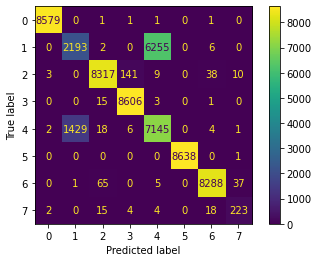

In [ ]:
dt_preds = dt.predict(x_train)
dt_predictions = dt.predict(test_df.loc[:, test_df.columns != ' Label'])
plot_confusion_matrix(dt, x_test, y_test)

In [ ]:
model = tf.keras.models.Sequential(layers=[
                                    tf.keras.layers.Dense(units=67, activation='relu', input_shape=(67,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(units=100, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(units=8, activation = 'softmax'),
])
model.compile(
        loss = 'categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics = [ 'accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                  ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 67)                4556      
                                                                 
 dropout (Dropout)           (None, 67)                0         
                                                                 
 dense_16 (Dense)            (None, 100)               6800      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 12,164
Trainable params: 12,164
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

In [ ]:
model.fit(x = x_train,
          y = y_train,
          batch_size=64,
          epochs=15,
          validation_split=0.1,
          )

Epoch 1/15
4789/4789 [==============================] - 62s 3ms/step - loss: 0.4216 - accuracy: 0.8069 - precision_5: 0.8319 - recall_5: 0.7753 - val_loss: 0.3355 - val_accuracy: 0.8407 - val_precision_5: 0.8419 - val_recall_5: 0.8389
Epoch 2/15
4789/4789 [==============================] - 15s 3ms/step - loss: 0.3312 - accuracy: 0.8301 - precision_5: 0.8370 - recall_5: 0.8209 - val_loss: 0.3158 - val_accuracy: 0.8418 - val_precision_5: 0.8433 - val_recall_5: 0.8403
Epoch 3/15
4789/4789 [==============================] - 13s 3ms/step - loss: 0.3217 - accuracy: 0.8320 - precision_5: 0.8377 - recall_5: 0.8245 - val_loss: 0.3122 - val_accuracy: 0.8261 - val_precision_5: 0.8272 - val_recall_5: 0.8243
Epoch 4/15
4789/4789 [==============================] - 13s 3ms/step - loss: 0.3152 - accuracy: 0.8327 - precision_5: 0.8376 - recall_5: 0.8261 - val_loss: 0.3091 - val_accuracy: 0.8275 - val_precision_5: 0.8286 - val_recall_5: 0.8251
Epoch 5/15
4789/4789 [==============================] - 13s 